In [2]:
"""
Speech Emotion Recognition using CNN-LSTM

This script processes audio files from a given dataset, extracts meaningful features, 
and trains a CNN-LSTM model to classify emotions.

Author: Prasanna Adhikari
GitHub: [Your GitHub URL]
"""

# Import necessary libraries
import os
import glob
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import librosa
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# Check GPU Availability (for personal use; not required for training)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Emotion Labels (RAVDESS Naming Convention)
emotions = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}
# Only a subset of emotions is used for training
observed_emotions = ['calm', 'happy', 'fearful', 'disgust', 'angry', 'sad']

# Ask the user for the dataset directory
dataset_directory = input("Enter the path to the dataset directory: ")

# Function to apply random data augmentation
def augment_audio(y, sr):
    """
    Apply random audio augmentation techniques:
    - Time stretching
    - Pitch shifting
    - Adding noise
    """
    if random.random() < 0.3:
        y = librosa.effects.time_stretch(y, rate=random.uniform(0.8, 1.2))  
    if random.random() < 0.3:
        y = librosa.effects.pitch_shift(y, sr=sr, n_steps=random.randint(-3, 3))  
    if random.random() < 0.3:
        noise = np.random.randn(len(y)) * 0.005  
        y = y + noise
    return y

# Function to extract audio features
def extract_features(file_name, n_mfcc=13, n_fft=2048, hop_length=512, fixed_width=130, augment=False):
    """
    Extracts multiple audio features including:
    - MFCCs and Delta MFCCs
    - Chroma
    - Spectral Contrast
    - Log-Mel Spectrogram

    All features are padded or truncated to a fixed width.
    """
    y, sr = librosa.load(file_name, sr=None)

    # Apply augmentation if enabled
    if augment:
        y = augment_audio(y, sr)  

    # Extract features
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    mfccs_delta = librosa.feature.delta(mfccs)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    mel_spec = librosa.power_to_db(librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length), ref=np.max)

    # Ensure all features have the same time width
    min_width = fixed_width
    mfccs = librosa.util.fix_length(mfccs, size=min_width, axis=1)
    mfccs_delta = librosa.util.fix_length(mfccs_delta, size=min_width, axis=1)
    chroma = librosa.util.fix_length(chroma, size=min_width, axis=1)
    spectral_contrast = librosa.util.fix_length(spectral_contrast, size=min_width, axis=1)
    mel_spec = librosa.util.fix_length(mel_spec, size=min_width, axis=1)

    # Stack features into a 2D array for CNN input
    features = np.vstack((mfccs, mfccs_delta, chroma, spectral_contrast, mel_spec))

    return features.T

# Function to load and preprocess the dataset
def load_data(test_size=0.2, augment=False):
    """
    Loads the dataset, extracts features, normalizes data, and splits into training and testing sets.
    """
    X, y = [], []

    for file in glob.glob(os.path.join(dataset_directory, "Actor_*/*.wav")):
        file_name = os.path.basename(file)
        emotion_code = file_name.split("-")[2]
        if emotion_code not in emotions:
            continue
        emotion = emotions[emotion_code]
        if emotion not in observed_emotions:
            continue
        
        # Extract features
        features = extract_features(file, augment=augment)
        X.append(features)
        y.append(emotion)

        # Apply data augmentation
        if augment:
            features_aug = extract_features(file, augment=True)
            X.append(features_aug)
            y.append(emotion)

    # Convert to numpy array
    X = np.array(X, dtype=np.float32)

    # Normalize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

    # Encode labels
    encoder = LabelEncoder()
    y = encoder.fit_transform(y)
    y = to_categorical(y)  

    return train_test_split(X, y, test_size=test_size, random_state=42), encoder

# Load data with augmentation
(X_train, X_test, y_train, y_test), encoder = load_data(test_size=0.25, augment=True)

# Compute class weights for handling imbalanced data
y_train_labels = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Define the CNN-LSTM model
model = Sequential([
    Conv1D(128, kernel_size=3, activation="relu", input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Conv1D(256, kernel_size=3, activation="relu"),
    MaxPooling1D(pool_size=2),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(6, activation="softmax")  # 6 emotion classes
])

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0005), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model
start_time = time.time()
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
                    class_weight=class_weights_dict, callbacks=[early_stopping, reduce_lr])

# Saving training history
with open("training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)
    
print(f"Training Time: {time.time() - start_time:.2f} seconds")

# Save the trained model
model.save("cnn_lstm_emotion_model.keras")

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Model Test Accuracy: {test_acc:.4f}")

Num GPUs Available:  1


Enter the path to the dataset directory:  /Users/prasannaadhikari/Downloads/Speech Emotion Recognition (SER)/ravdess_data


2025-02-26 12:54:39.699357: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-02-26 12:54:39.699637: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-02-26 12:54:39.700500: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-02-26 12:54:39.700788: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-26 12:54:39.701330: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2025-02-26 12:54:41.776211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-26 12:54:42.419190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-26 12:54:42.754262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-26 12:54:44.310792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-26 12:54:44.983293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


53/54 [============================>.] - ETA: 0s - loss: 1.7908 - accuracy: 0.2022

2025-02-26 12:54:46.835094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-26 12:54:46.913739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-26 12:54:46.953422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 6s 30ms/step - loss: 1.7910 - accuracy: 0.2020 - val_loss: 1.7281 - val_accuracy: 0.2847 - lr: 5.0000e-04
Epoch 2/100
54/54 [==============================] - 1s 22ms/step - loss: 1.6245 - accuracy: 0.3021 - val_loss: 1.4720 - val_accuracy: 0.3733 - lr: 5.0000e-04
Epoch 3/100
54/54 [==============================] - 1s 21ms/step - loss: 1.5010 - accuracy: 0.3681 - val_loss: 1.3980 - val_accuracy: 0.4236 - lr: 5.0000e-04
Epoch 4/100
54/54 [==============================] - 1s 22ms/step - loss: 1.3988 - accuracy: 0.4074 - val_loss: 1.3962 - val_accuracy: 0.4149 - lr: 5.0000e-04
Epoch 5/100
54/54 [==============================] - 1s 24ms/step - loss: 1.3118 - accuracy: 0.4473 - val_loss: 1.2385 - val_accuracy: 0.5052 - lr: 5.0000e-04
Epoch 6/100
54/54 [==============================] - 1s 22ms/step - loss: 1.1753 - accuracy: 0.5110 - val_loss: 1.2213 - val_accuracy: 0.5122 - lr: 5.0000e-04
Epoch 7/100
54/54 [==============================] - 1s 21

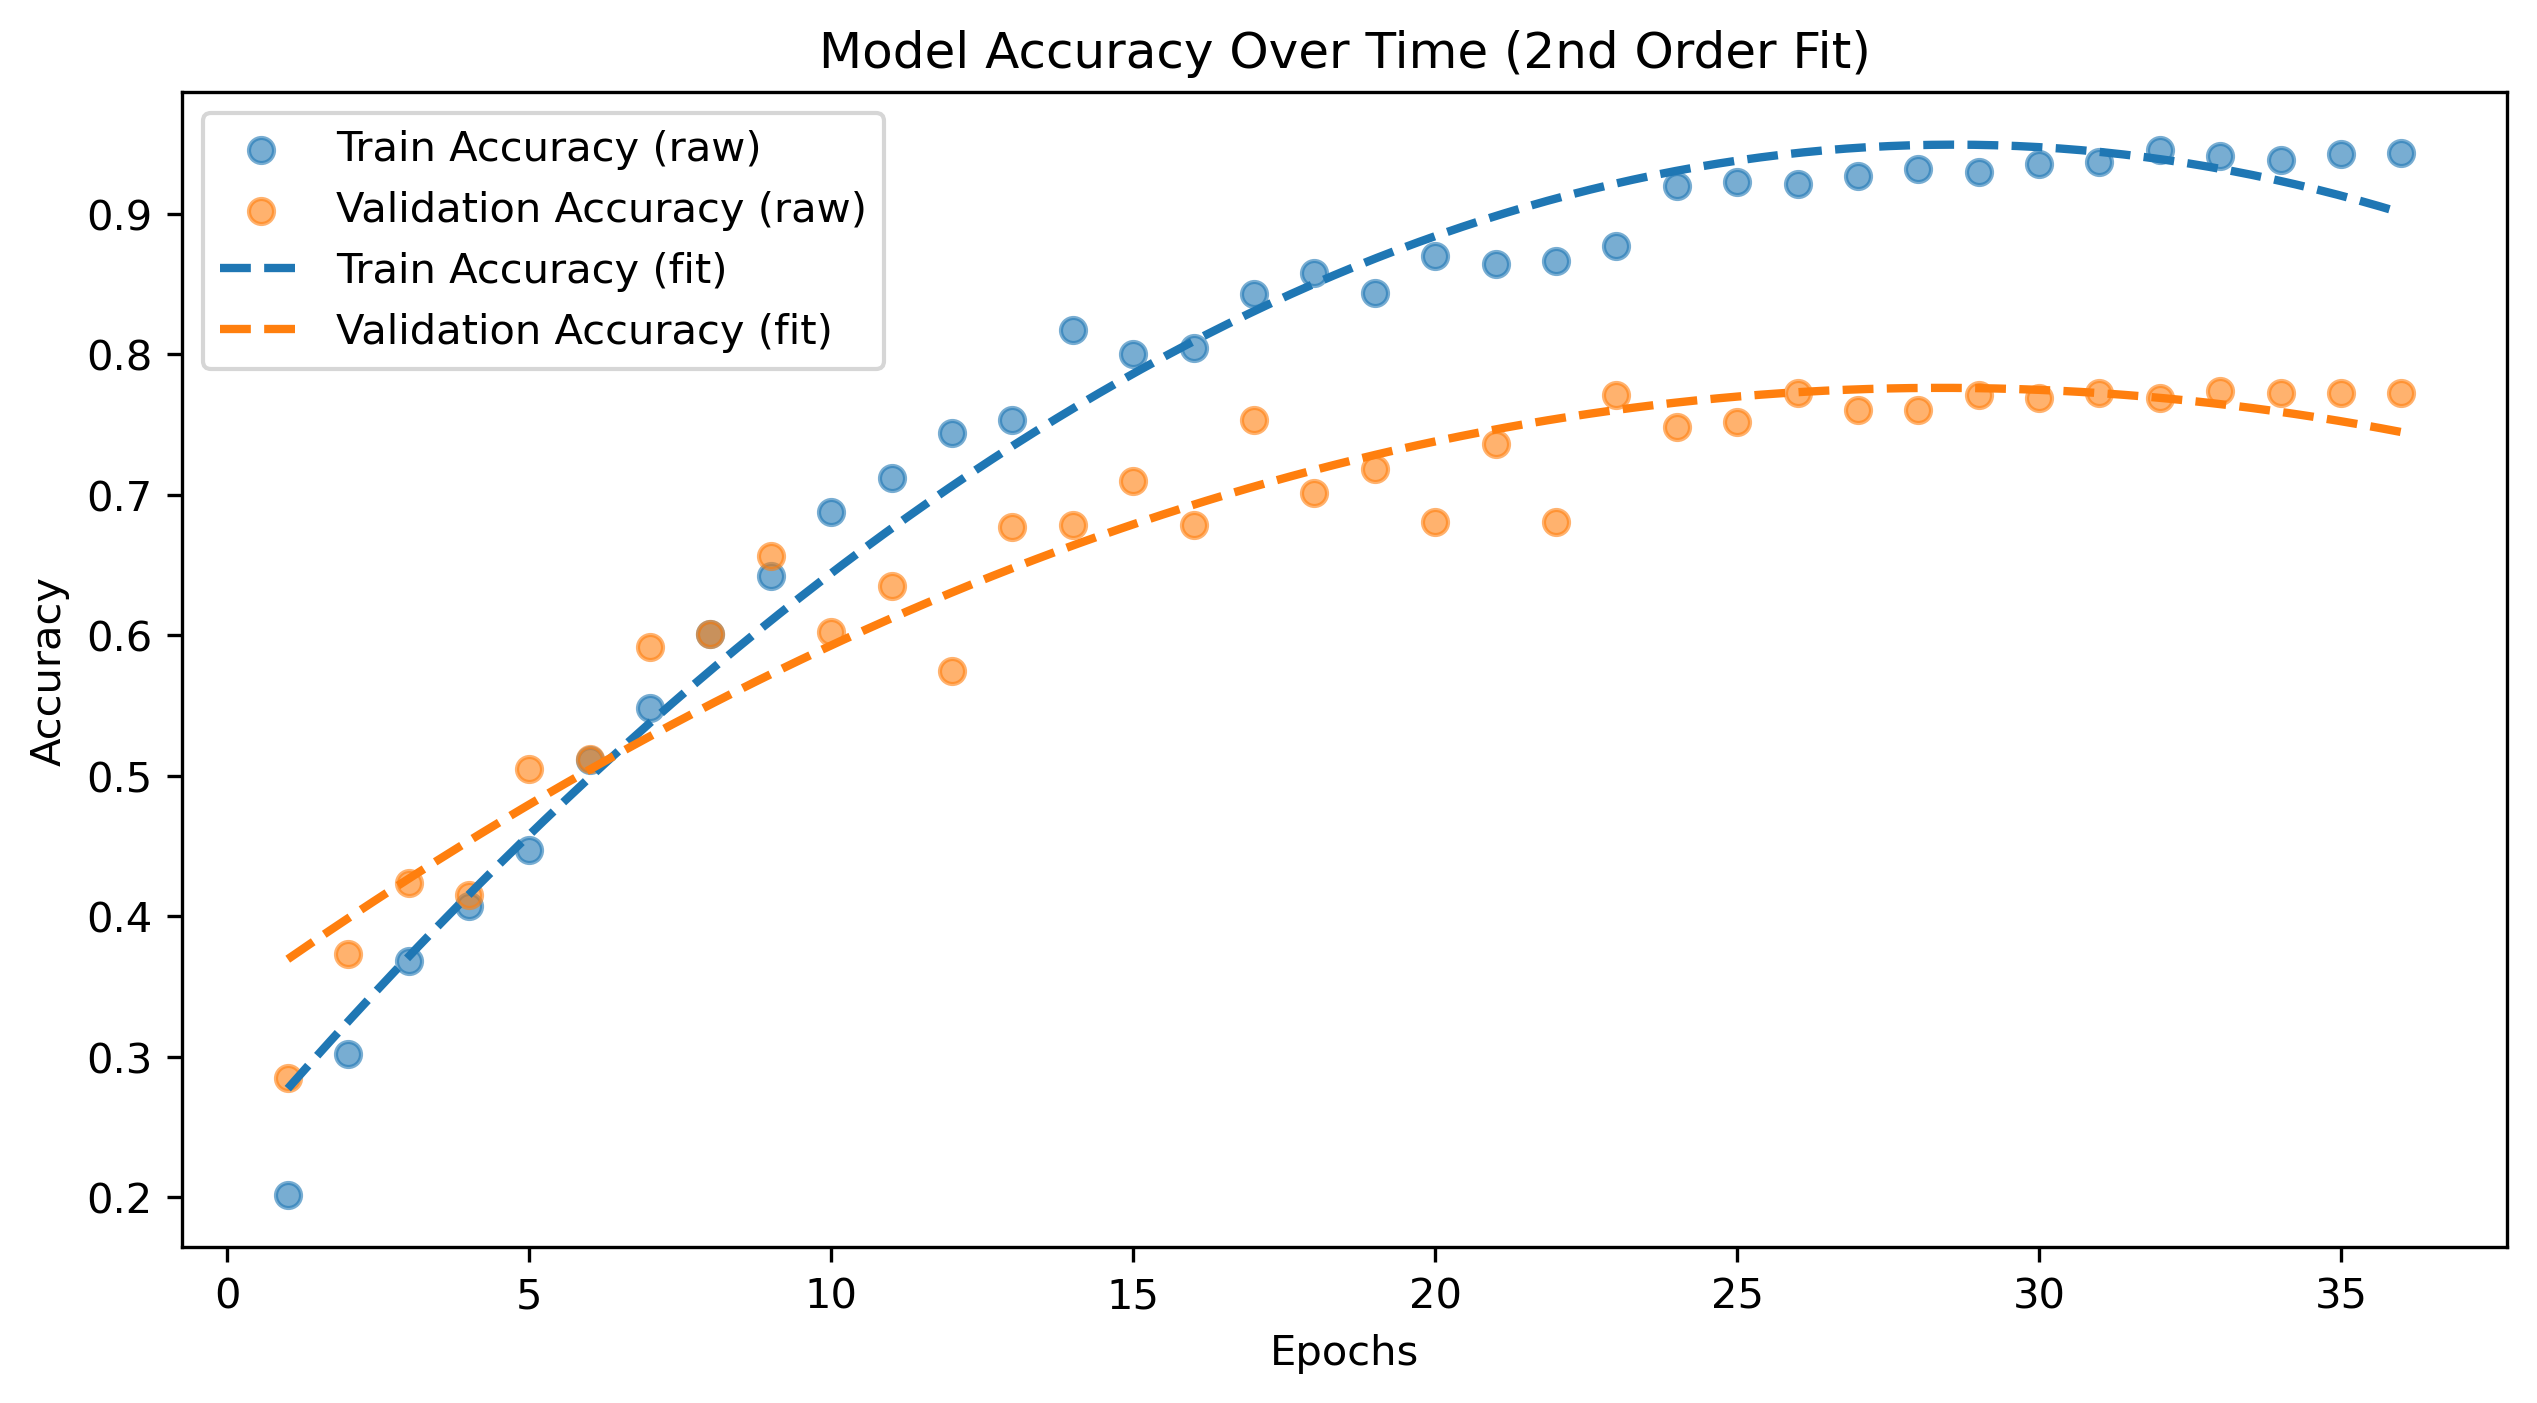

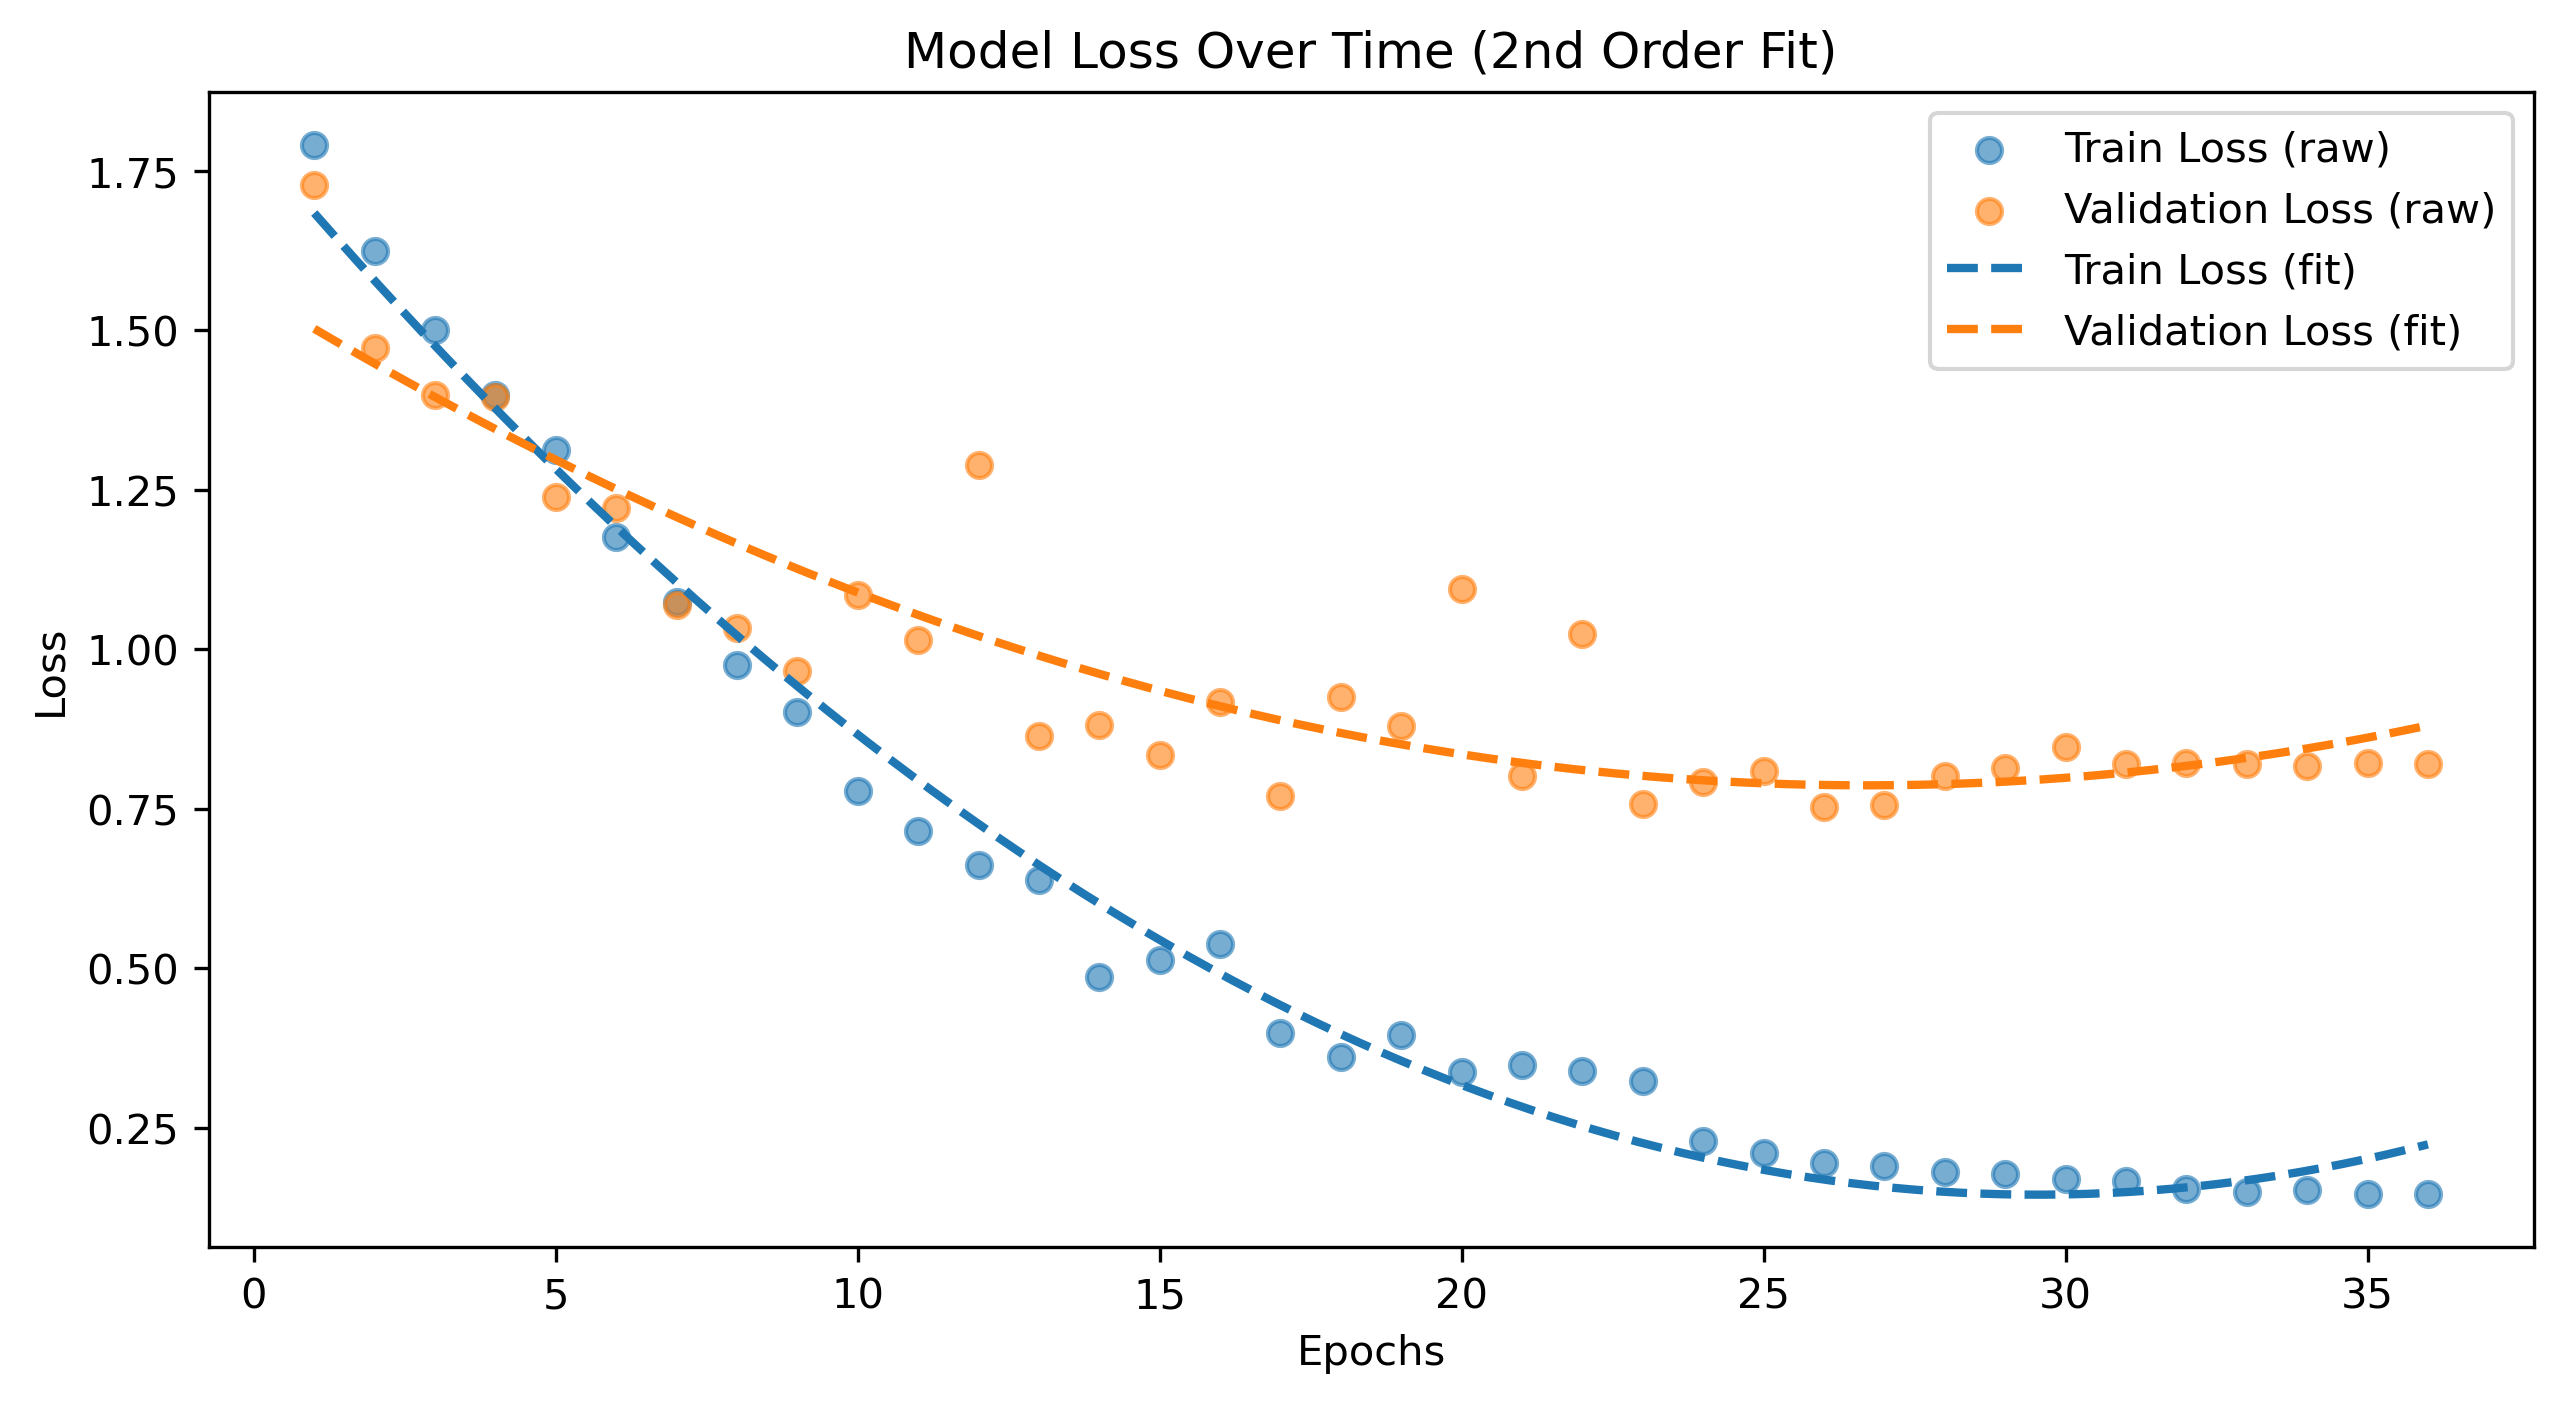

Train Accuracy Polynomial Coefficients: [-0.00088275  0.05047191  0.22783176]
Validation Accuracy Polynomial Coefficients: [-0.00054228  0.03078325  0.33931464]
Train Loss Polynomial Coefficients: [ 0.00188923 -0.1116137   1.79363773]
Validation Loss Polynomial Coefficients: [ 1.08380528e-03 -5.78689683e-02  1.55928672e+00]


In [10]:
def fit_polynomials(history):
    """
    Fits 2nd-degree polynomials to accuracy and loss curves from model training history.

    Parameters:
        history: Dictionary containing training history (not a Keras History object).

    Returns:
        Dictionary containing polynomial coefficients and smoothed curve data.
    """
    epochs = np.arange(1, len(history['accuracy']) + 1)

    # Fit 2nd-order polynomials
    poly_acc = np.polyfit(epochs, history['accuracy'], deg=2)
    poly_val_acc = np.polyfit(epochs, history['val_accuracy'], deg=2)
    poly_loss = np.polyfit(epochs, history['loss'], deg=2)
    poly_val_loss = np.polyfit(epochs, history['val_loss'], deg=2)

    return {
        "poly_acc": poly_acc,
        "poly_val_acc": poly_val_acc,
        "poly_loss": poly_loss,
        "poly_val_loss": poly_val_loss,
    }


def plot_accuracy_loss(history):
    """
    Plots model accuracy and loss over epochs, including polynomial trend lines.

    Parameters:
        history: A dictionary containing training metrics.
    """
    fit_results = fit_polynomials(history)

    epochs = np.arange(1, len(history['accuracy']) + 1)
    epochs_smooth = np.linspace(1, len(history['accuracy']), 100)  

    # Generate smoothed curves
    acc_smooth = np.polyval(fit_results["poly_acc"], epochs_smooth)
    val_acc_smooth = np.polyval(fit_results["poly_val_acc"], epochs_smooth)
    loss_smooth = np.polyval(fit_results["poly_loss"], epochs_smooth)
    val_loss_smooth = np.polyval(fit_results["poly_val_loss"], epochs_smooth)

    # Plot Accuracy
    plt.figure(figsize=(10, 5), dpi=300)
    plt.scatter(epochs, history['accuracy'], label='Train Accuracy (raw)', alpha=0.6)
    plt.scatter(epochs, history['val_accuracy'], label='Validation Accuracy (raw)', alpha=0.6)
    plt.plot(epochs_smooth, acc_smooth, label='Train Accuracy (fit)', linestyle='--', linewidth=2)
    plt.plot(epochs_smooth, val_acc_smooth, label='Validation Accuracy (fit)', linestyle='--', linewidth=2)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Accuracy Over Time (2nd Order Fit)')
    plt.show()

    # Plot Loss
    plt.figure(figsize=(10, 5), dpi=300)
    plt.scatter(epochs, history['loss'], label='Train Loss (raw)', alpha=0.6)
    plt.scatter(epochs, history['val_loss'], label='Validation Loss (raw)', alpha=0.6)
    plt.plot(epochs_smooth, loss_smooth, label='Train Loss (fit)', linestyle='--', linewidth=2)
    plt.plot(epochs_smooth, val_loss_smooth, label='Validation Loss (fit)', linestyle='--', linewidth=2)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Loss Over Time (2nd Order Fit)')
    plt.show()

    # Print polynomial coefficients
    print("Train Accuracy Polynomial Coefficients:", fit_results["poly_acc"])
    print("Validation Accuracy Polynomial Coefficients:", fit_results["poly_val_acc"])
    print("Train Loss Polynomial Coefficients:", fit_results["poly_loss"])
    print("Validation Loss Polynomial Coefficients:", fit_results["poly_val_loss"])

try:
    # Load history dictionary
    with open("training_history.pkl", "rb") as f:
        history_dict = pickle.load(f)  # This is now a dictionary
    plot_accuracy_loss(history_dict)  # Pass directly to the function
except FileNotFoundError:
    print("No saved training history found. Run model training first.")